<a href="https://colab.research.google.com/github/tdbartolo/tdbartolo-rep/blob/main/PNL_transformer_aula_coment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face

In [4]:
from datasets import load_dataset

# carregando dados do HF

dataset = load_dataset("yelp_review_full")

# carregando dados locais

#dataset = load_dataset('csv', data_files={'train': 'train_small.csv', 'test': 'test_small.csv'},
                            #  column_names=['label', 'text'], skiprows=[0])
#dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer



Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [6]:
#verifica quantos labels únicos temos
set(dataset["train"]["label"])

{0, 1, 2, 3, 4}

In [7]:
#mostra a quantidade de linhas do dataset no train e  no test
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [8]:
# gerando datasets menores (pra poupar tempo)

small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1500))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

In [9]:
import pandas as pd

small_train_labels = small_train_dataset["label"]
small_train_texts = small_train_dataset["text"]

# Criar DataFrames para os conjuntos menores de dados
small_train_df = pd.DataFrame({'label': small_train_labels, 'text': small_train_texts})

small_train_df.head(10)

,label,text
0,4,I stalk this truck. I've been to industrial p...
1,2,"who really knows if this is good pho or not, i..."
2,4,I LOVE Bloom Salon... all of their stylist are...
3,0,"We were excited to eat here, it is difficult t..."
4,2,"So this is a place, with food. That much canno..."
5,2,Review for the Lounge/Club:\nEvery time I go t...
6,3,I've been going here a lot(pretty much a regul...
7,0,I went to Sole on the weekend and found that i...
8,0,Went in on a sunday afternoon. Place was dead....
9,4,I have lived here in Phoenix for 9 months now ...


In [26]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [27]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [28]:
tokenized_small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [29]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    max_steps=200,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=10,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,1.369700,1.439193,0.378000
20,1.300300,1.342919,0.452000
30,1.326400,1.252101,0.472000
40,1.123900,1.191683,0.468000
50,1.087900,1.122576,0.526000
60,0.992500,1.116997,0.512000
70,0.911300,1.091787,0.520000
80,0.849700,1.115119,0.542000
90,0.801000,1.109055,0.524000
100,0.774000,1.088293,0.566000


In [ ]:
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.5162,0.000028,0.03,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5047,0.000027,0.06,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.4194,0.000025,0.10,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2716,0.000024,0.13,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.2106,0.000023,0.16,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.16,50,1.185575,0.476,17.3049,28.894,3.641,NaN,NaN,NaN,NaN,NaN
6,1.1852,0.000021,0.19,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0719,0.000019,0.22,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0624,0.000018,0.26,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0401,0.000017,0.29,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

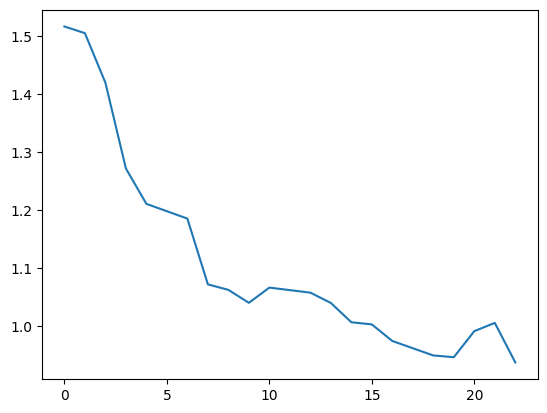

In [ ]:
df_log["loss"].dropna().plot()

<Axes: >

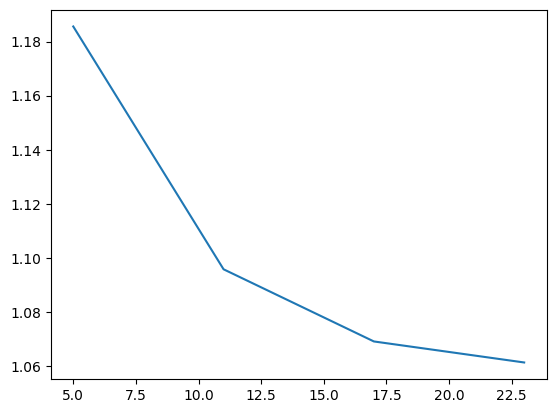

In [ ]:
df_log["eval_loss"].dropna().plot()

<Axes: >

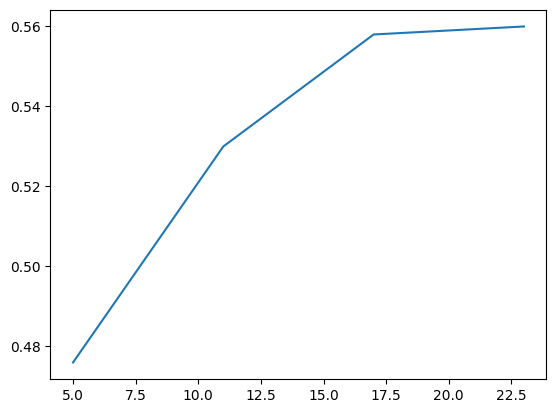

In [ ]:
df_log["eval_accuracy"].dropna().plot()

In [ ]:
trainer.evaluate(tokenized_small_test_dataset)

{'eval_loss': 0.9414300918579102,
 'eval_accuracy': 0.584,
 'eval_runtime': 18.7295,
 'eval_samples_per_second': 26.696,
 'eval_steps_per_second': 3.364,
 'epoch': 0.64}

In [ ]:
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('modelo_aula_bert/tokenizer_config.json',
 'modelo_aula_bert/special_tokens_map.json',
 'modelo_aula_bert/vocab.txt',
 'modelo_aula_bert/added_tokens.json',
 'modelo_aula_bert/tokenizer.json')

In [ ]:
import torch.nn.functional as F
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

text = "This is a really excellent restaurant, but the drink was hot"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
probs = F.softmax(output.logits, dim=1)
pred = torch.argmax(probs, dim=1)
print(probs)
pred

tensor([[0.0095, 0.0761, 0.5459, 0.3074, 0.0610]], grad_fn=<SoftmaxBackward0>)


tensor([2])

In [ ]:
encoded_input

{'input_ids': tensor([[ 101, 1188, 1110,  170, 1541, 2213, 4382,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}